In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

import cv2
from cv2 import dilate
from cv2 import adaptiveThreshold

from os import listdir
from os.path import isfile, join

from skimage import io

from sklearn.externals import joblib

In [2]:
clf = joblib.load('model.pkl')

In [3]:
def cv_remove_small_objects(im, min_size):
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(im, connectivity=8)
    sizes = stats[1:, -1]; 
    nb_components = nb_components - 1

    res = np.zeros((output.shape))
    for i in range(0, nb_components):
        if sizes[i] >= min_size:
            res[output == i + 1] = 1
            
    return res

def binarize(im):
    binary_local = im=cv2.adaptiveThreshold(
        src=np.array(cv2.medianBlur(im, 5), dtype=np.uint8), 
        maxValue=255, 
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        thresholdType=cv2.THRESH_BINARY_INV, 
        blockSize=505, 
        C=25)
    
    cleaned = cv_remove_small_objects(binary_local, 250)
    
    strel = cv2.getStructuringElement(cv2.MORPH_RECT,(40, 40))    
    cleaned = cv2.dilate(np.array(cleaned, dtype=np.uint8), strel)
    
    cleaned = cv_remove_small_objects(cleaned, 15000)
    
    return cleaned

def get_next_notch_center(im, clf):    
    nb_components, output, stats, centroids = \
        cv2.connectedComponentsWithStats(np.array(im, dtype=np.uint8), connectivity=4)
    
    stats = np.array(stats)
    stats = stats[:, 2:5]
    
    c_x, c_y = [s/2 for s in im.shape]
    dists = [((c_x-x)**2+(c_y-y)**2)**.5 for x, y in centroids[1:]]
    nh_ix = dists.index(min(dists)) + 1
    x, y = centroids[nh_ix]
    x, y = x-c_x, y-c_y
    if clf.predict([stats[nh_ix]])[0]:
        return (x, y)
    else:
        return (None, None)


def parse_filename(fname):
    fname = fname.split('.')[0]
    x, y = [float(i.replace(',', '.')) for i in fname.split('x')]
    return x, y

In [4]:
path=os.getcwd() + '\\photo1\\'
impaths = [f for f in listdir(path) if isfile(join(path, f))]

In [5]:
%%time

notch_center_x = []
notch_center_y = []

im_center_x = []
im_center_y = []

notch=[]
not_notch=[]

for n, impath in enumerate(impaths):
    print("processing " + impath + " " + "({} of {})".format(n+1, len(impaths)))
    image = cv2.imread(path+impath, cv2.IMREAD_GRAYSCALE)
    bimage = binarize(image)
    
    io.imsave(os.getcwd() + '\\binarized\\' + impath, bimage)
    
    nh_center_x, nh_center_y = get_next_notch_center(bimage, clf)
    if nh_center_x is None:
        print('This is not a notch!')
        not_notch.append(impath)
        continue
        
    notch.append(impath)
    
    notch_center_x.append(nh_center_x)
    notch_center_y.append(nh_center_y)
    
    im_x, im_y = parse_filename(impath)
    im_center_x.append(im_x)
    im_center_y.append(im_y)
    
notch_center_x = np.array(notch_center_x)
notch_center_y = np.array(notch_center_y)
im_center_x = np.array(im_center_x)
im_center_y = np.array(im_center_y)

processing 0x0.jpg (1 of 54)


D:\Anaconda3\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


This is not a notch!
processing 0x13,87.jpg (2 of 54)
processing 0x21,92.jpg (3 of 54)
processing 0x29,92.jpg (4 of 54)
processing 0x37,83.jpg (5 of 54)
processing 0x45,97.jpg (6 of 54)
processing 0x5,89.jpg (7 of 54)
This is not a notch!
processing 0x53,98.jpg (8 of 54)
processing 0x61,97.jpg (9 of 54)
processing 0x69,98.jpg (10 of 54)
processing 0x77,96.jpg (11 of 54)
This is not a notch!
processing 0x84,05.jpg (12 of 54)
This is not a notch!
processing 101,76x84,05.jpg (13 of 54)
processing 101,96x0.jpg (14 of 54)
processing 109,90x84,05.jpg (15 of 54)
processing 110,05x0.jpg (16 of 54)
processing 117,76x84,05.jpg (17 of 54)
processing 117,95x0.jpg (18 of 54)
processing 125,70x84,05.jpg (19 of 54)
This is not a notch!
processing 126,03x0.jpg (20 of 54)
This is not a notch!
processing 13,81x84,05.jpg (21 of 54)
processing 131,95x0.jpg (22 of 54)
This is not a notch!
processing 131,95x13,96.jpg (23 of 54)
This is not a notch!
processing 131,95x21,91.jpg (24 of 54)
processing 131,95x29

In [6]:
not_notch

['0x0.jpg',
 '0x5,89.jpg',
 '0x77,96.jpg',
 '0x84,05.jpg',
 '125,70x84,05.jpg',
 '126,03x0.jpg',
 '131,95x0.jpg',
 '131,95x13,96.jpg',
 '131,95x45,91.jpg',
 '131,95x62,04.jpg',
 '131,95x69,98.jpg',
 '131,95x77,99.jpg',
 '131,95x84,05.jpg',
 '29,82x84,05.jpg',
 '5,74x84,05.jpg',
 '6,01x0.jpg',
 '77,80x84,05.jpg']

In [7]:
pix = 1275
mm = 8
pix_mm = 1275/8
mm_pix = 8/1275

print('Между засечками 1275 пикселей')
print('Между засечками 8 мм')
print('В 1 мм {:.3f} пикселей'.format(mm_pix))
print('В 1 пикселе {:.3f} мм'.format(pix_mm))

Между засечками 1275 пикселей
Между засечками 8 мм
В 1 мм 0.006 пикселей
В 1 пикселе 159.375 мм


In [8]:
notch_center_x=np.array([x/pix_mm for x in notch_center_x])
notch_center_y=np.array([y/pix_mm for y in notch_center_y])

In [9]:
notch_x = [x1+x2 for x1, x2 in zip(notch_center_x, im_center_x)]
notch_y = [y1+y2 for y1, y2 in zip(notch_center_y, im_center_y)]

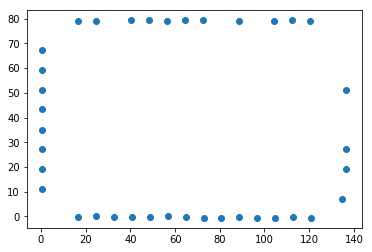

In [10]:
plt.scatter(x=notch_x, y=notch_y)